# Температура звёзд

## Постановка задачи

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

### Характеристики

* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды.
  
| Тип звезды | Номер, соответствующий типу |
|----------|----------|
| Коричневый карлик | 0 |
| Красный карлик    | 1 |
| Белый карлик      | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант    | 4 |
| Гипергигант      | 5 |

* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

### Цель проекта

В этом проекте нам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

Загружаем все необходимые библиотеки.

In [1]:
!pip install ydata-profiling
!pip install torch
!pip install PyQt6
!pip install matplotlib==3.7.3

  Using cached matplotlib-3.7.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.1
    Uninstalling matplotlib-3.9.1:
      Successfully uninstalled matplotlib-3.9.1


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Загружаем наш датасет и проведём первчиный осмотр данных.

In [3]:
try:
    df = pd.read_csv('6_class1.csv', index_col = 0)
except:
    df = pd.read_csv('/datasets/6_class.csv', index_col = 0)

In [4]:
df.info()
print()
display(df.head())
display(df.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB



,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


### Выводы

* В данных не так много объектов, всего 240.
* Наименования столбцов не соответствуют стандартам.
* Пропуски в данных не обнаружены.

## Предобработка и анализ данных

Переименуем все названия столбцов в соответствии со стандартами.

In [5]:
df.rename(columns={
    'Temperature (K)':'temperature',
    'Luminosity(L/Lo)':'luminosity',
    'Radius(R/Ro)':'radius',
    'Absolute magnitude(Mv)':'magnitude',
    'Star type':'star_type',
    'Star color':'color'
}, inplace=True)

Видим, что у нас один столбец с текстовыми характеристиками - ***color***. Посмотрим на его уникальные значения:

In [6]:
df['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Приведём всё к единому виду, чтобы не было повторений.

In [7]:
df['color'] = df['color'].str.strip()
df['color'] = df['color'].str.lower()
df['color'] = df['color'].str.replace('-', ' ')

Проверяем результат:

In [8]:
df['color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

Замечаем, что у нас 2 одинаковых цвета записаны в разном порядке - *yellow white* и *white yellow*. Избавимсяот неявных дубликатов и проверим результат.

In [9]:
df['color'] = df['color'].replace('yellow white', 'white yellow')

In [10]:
df['color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'white yellow', 'orange',
       'yellowish', 'orange red'], dtype=object)

Удалим редкие категории цвета, которые имеют численность меньше 3, принимая их за выбросы.

In [11]:
df = df[~df['color'].isin(df.color.value_counts()[df.color.value_counts() < 3].index)]

In [12]:
df.reset_index(drop=True, inplace=True)

Также приведём наши категориальные признаки к соответствующему типу данных.

In [13]:
df['star_type'] = df['star_type'].astype('category')
df['color'] = df['color'].astype('category')

Выведем итоговую информацию о датасете.

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Вывод

* В данных отсутствуют пропущенные значения и явные дубликаты.
* Распределение объектов по типам звёзд равномерное.
* По таблицам корреляции видно, что температура имеет наибольшую корреляцию с магнитудой (-52%) и относительной светимостью (48,4%). С остальными характеристиками корреляция ниже средней.
* Можем также отметить высокую мультиколлинеарность между признаками: радиус и относительная светимость коррелируют между собой на 89%, относительная светимость и магнитуда на -89,1%, магнитуда и радиус на -86,7%.

## Подготовка данных

Разделим данные на обучающую и тестовую выборки.

In [15]:
df

,temperature,luminosity,radius,magnitude,star_type,color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red
...,...,...,...,...,...,...
229,38940,374830.000000,1356.0000,-9.93,5,blue
230,30839,834042.000000,1194.0000,-10.63,5,blue
231,8829,537493.000000,1423.0000,-10.73,5,white
232,9235,404940.000000,1112.0000,-11.23,5,white


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('temperature', axis = 1),
                                                    df['temperature'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(187, 5) (47, 5) (187,) (47,)


С помощь инструмента *ColumnTransformer()* преобразуем данные - категориальные характеристики закодируем с помощью *OHE*, а числовые данные стандартизируем с помощью *StandardScaler()*.

In [17]:
numerics = ['luminosity','radius','magnitude']
categorical = ['star_type', 'color']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(df.drop('temperature', axis=1))
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

Далее переходим к построению базовой нейронной сети.

## Построение базовой нейронной сети

Переводим наши выборки в тензоры.

In [18]:
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

Создаём первоначальную базовую нейронную сеть.

In [19]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

Определяем количество нейронов на каждом из уровней, активизируем нашу НС и задаём функцию метрики.

In [20]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

Преобразуем наши тензоры в датасеты

In [21]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

In [22]:
train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)

Далее напишем функцию для инструмента *CustomEarlyStopping()*, блягодаря которому мы сможем избежать переобучения при обучении модели.

In [23]:
class CustomEarlyStopping():

    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

Обучим нашу НС.

In [24]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=0)

num_epochs = 100000
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()

    if epoch % 200 == 0:
        predicted_temp = []
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
        RMSE
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
        print(f"epoch:{epoch}, RMSE test: {RMSE}")

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break

epoch:0, RMSE test: 16014.6279296875
epoch:200, RMSE test: 14505.66015625
epoch:400, RMSE test: 9853.3740234375
epoch:600, RMSE test: 8756.5751953125
epoch:800, RMSE test: 8491.263671875
epoch:1000, RMSE test: 8193.53125
epoch:1200, RMSE test: 7894.28466796875
epoch:1400, RMSE test: 7568.12255859375
epoch:1600, RMSE test: 7232.80908203125
epoch:1800, RMSE test: 6912.52392578125
epoch:2000, RMSE test: 6589.2998046875
epoch:2200, RMSE test: 6316.650390625
epoch:2400, RMSE test: 6060.517578125
epoch:2600, RMSE test: 5856.90380859375
epoch:2800, RMSE test: 5691.10595703125
epoch:3000, RMSE test: 5550.2626953125
epoch:3200, RMSE test: 5439.935546875
epoch:3400, RMSE test: 5360.4912109375
epoch:3600, RMSE test: 5309.3876953125
epoch:3800, RMSE test: 5258.83837890625
epoch:4000, RMSE test: 5227.07568359375
epoch:4200, RMSE test: 5195.47265625
epoch:4400, RMSE test: 5168.81201171875
epoch:4600, RMSE test: 5151.4375
epoch:4800, RMSE test: 5135.43359375
epoch:5000, RMSE test: 5118.66162109375
ep

Пропишем функцию для графика "Факт-прогноз".

In [25]:
%matplotlib inline

In [26]:
def fact_forecast(test_preds, y_test):
    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()
    


Строим график с нашими предсказаниями и правильными данными.

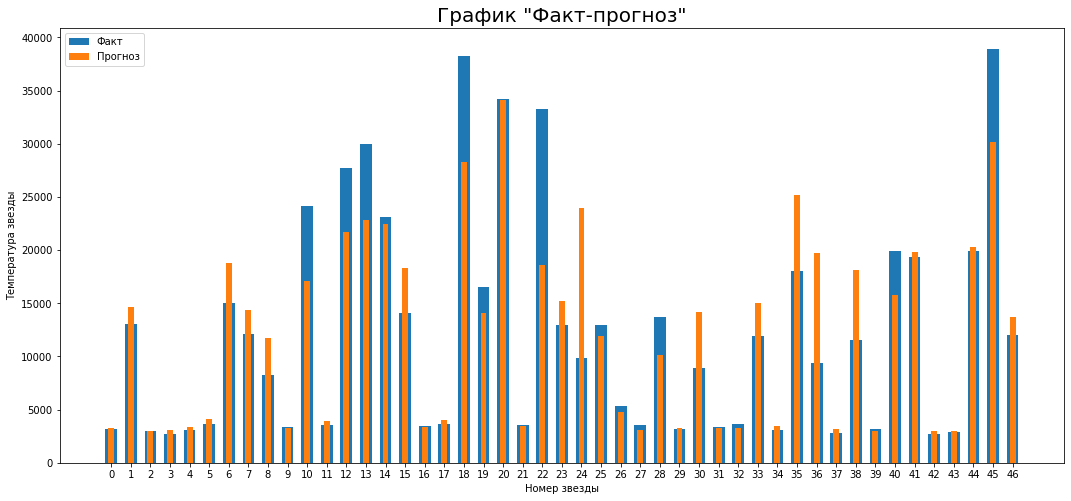

In [27]:
fact_forecast(predicted_temp, y_test)

### Вывод

Нам удалось обучить базовую модель НС без дополнительных введений и перебора параметров. Лучшая метрика RMSE до начала переобучения равна 4931. Однако, это не лучший результат, которого мы можем добиться, далее будем улучшаять нашу НС. Судя по графику факт-прогноз мы отлично угадываем температуру звёзд с минимальным отклонением до 5000 градусов по Кельвину в большинстве случаев. Можем также отметить, что на более низких температурах модель явно лучше справялется с предсказаниями, нежели когда речь идёт о более высоких значениях таргета. Возможно, это связано с небольшим количеством подобных звёзд в нашей выборке, НС просто не смогла правильно научиться на таком малом количестве данных.

## Улучшение нейронной сети

В качестве улучшения модели попробуем перебрать разные оптимизаторы с различными гиперпараметрами, соберём в общую таблицу и сравним, какой оптимизатор даст лучший результат.

In [28]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]

In [29]:
rmse_optimizers = []
for optimizer in optimizers:
    print(optimizer)
    print()

    early_stopping = CustomEarlyStopping(patience=5, min_delta=0)

    num_epochs = 100001
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch # просто выгружаем данные
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        if epoch % 200 == 0:
            predicted_temp = []
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temperature_test = batch # просто выгружаем данные

                    test_preds = net.forward(data_test).flatten()
                    predicted_temp.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
            early_stopping(RMSE)
            if early_stopping.counter == 0:
                best_rmse = RMSE
                best_predicted_temp = predicted_temp
            print(f"epoch:{epoch}, RMSE test: {RMSE}")

            if early_stopping.early_stop:
                print('Early Stoppning!!!')
                print(f'Best RMSE test {best_rmse}')
                rmse_optimizers.append(round(best_rmse, 2))
                break


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

epoch:0, RMSE test: 16015.0849609375
epoch:200, RMSE test: 14434.162109375
epoch:400, RMSE test: 9771.3154296875
epoch:600, RMSE test: 8798.2333984375
epoch:800, RMSE test: 8526.4404296875
epoch:1000, RMSE test: 8215.1962890625
epoch:1200, RMSE test: 7896.73486328125
epoch:1400, RMSE test: 7562.85498046875
epoch:1600, RMSE test: 7216.29248046875
epoch:1800, RMSE test: 6874.37060546875
epoch:2000, RMSE test: 6563.2734375
epoch:2200, RMSE test: 6267.1162109375
epoch:2400, RMSE test: 6018.55419921875
epoch:2600, RMSE test: 5814.81103515625
epoch:2800, RMSE test: 5661.66455078125
epoch:3000, RMSE test: 5521.6025390625
epoch:3200, RMSE test: 5433.18359375
epoch:3400, RMSE test: 5354.95849609375
epoch:3600, RMSE test: 5303.08349609375
epoch:3800, RMSE test: 5265.849609375
epoch:4000, RMSE test: 5227.80322265625
epoch:4200, RMSE test: 5211.85693359375
epoch:4400, RMSE test: 

In [30]:
optimizers_rmse = pd.DataFrame(data = rmse_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01'], columns = ['RMSE'])
display(optimizers_rmse.sort_values(by='RMSE'))

,RMSE
"Adam, lr: 0.01",4489.410156
"Adamax, lr: 0.01",4739.020020
"NAdam, lr: 0.01",4742.979980
"Adamax, lr: 0.001",4755.799805
"Adam, lr: 0.001",4977.379883


В таблице видим, что лучших результатов смог добиться оптимизатор *Adam* с параметром *lr = 0.01*. Его и будем использовать для модели с регуляризацией.

Далее посмотрим нашу базовую НС и посмотрим, как изменится наша метрика после применения нескольких способов регуляризации («dropout» и «размер батча») на разных слоях. С помощью перебора посмотрим, где самые лучшие метрики, сравним их и выберем лучшее сочетание.

Сначала будем применять метод регуляризации **Batch Normalization**. По очереди будем применять его только к первому скрытому слою, далее ко второму и в последний момент к обоим слоям.

In [31]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [32]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [33]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)

In [34]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=0)

num_epochs = 100001
val_loss = []
train_loss = []

for epoch in range(num_epochs):
    net.train()
    train_loss_batches = []
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))

        loss_value.backward()
        optimizer.step()

        loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)


    if epoch % 200 == 0:
        predicted_temp = []
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)


        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
            val_loss.append(best_rmse)
            train_loss.append(np.mean(train_loss_batches))
        print(f"epoch:{epoch}, RMSE test: {RMSE}")


        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break

epoch:0, RMSE test: 16015.041015625
epoch:200, RMSE test: 12430.2822265625
epoch:400, RMSE test: 5361.16650390625
epoch:600, RMSE test: 4551.87060546875
INFO: Early stopping counter 1 of 5
epoch:800, RMSE test: 4603.60205078125
INFO: Early stopping counter 2 of 5
epoch:1000, RMSE test: 4641.677734375
INFO: Early stopping counter 3 of 5
epoch:1200, RMSE test: 4650.56103515625
INFO: Early stopping counter 4 of 5
epoch:1400, RMSE test: 4631.0712890625
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1600, RMSE test: 4625.41796875
Early Stoppning!!!
Best RMSE test 4551.87060546875


По итогу расчётов имеем следующие результаты:
* при регуляризации только на первом скрытом слое имеем метрику  **4536**,
* только на втором скрытом слое метрика равна **4511**,
* на двух слоях сразу метрика имеет значение **4488**.

Исходя из практических расчётов видим, что лучший результат дала НС с регуляризацией на обоих скрытых слоях сразу, поэтому следующие расчёты будем сравнивать с этой моделью.

Построим график "Факт-Прогноз" для лучшей модели с регуляризацией **Batch Normalization**.

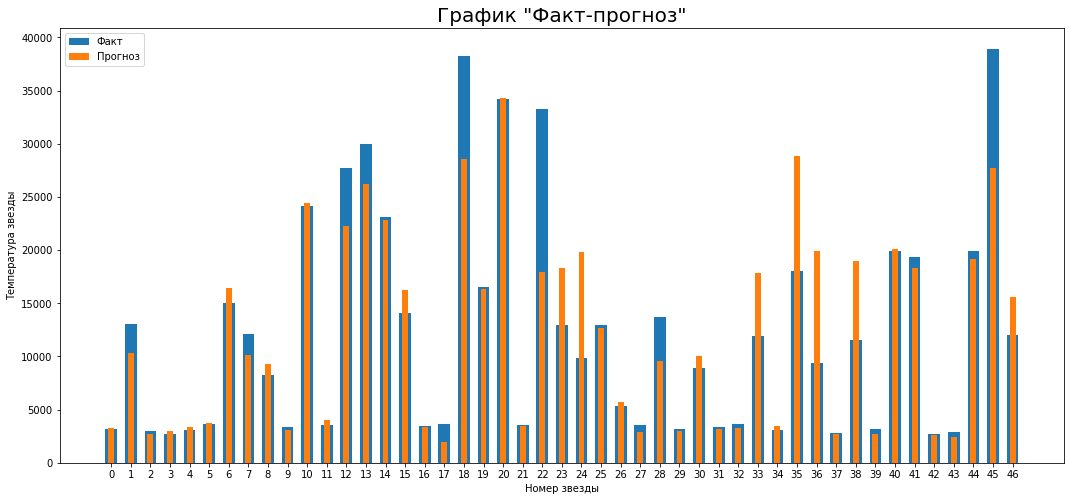

In [35]:
fact_forecast(predicted_temp, y_test)

Даже с первого вгляда в сравнении с первым графиком уже заметны явные улучшения.

Переходим к регуляризации с помощью метода **Dropout**. Перебирать будем также, как и с предыдущим методом.

In [36]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp1 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            #self.dp2 = nn.Dropout(p=0.5)
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        #x = self.dp2(x)
        x = self.fc3(x)

        return x

In [37]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [38]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)

In [39]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=0)

num_epochs = 100001
val_loss = []
train_loss = []

for epoch in range(num_epochs):
    net.train()
    train_loss_batches = []
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))

        loss_value.backward()
        optimizer.step()

        loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)


    if epoch % 200 == 0:
        predicted_temp = []
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)


        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
            val_loss.append(best_rmse)
            train_loss.append(np.mean(train_loss_batches))
        print(f"epoch:{epoch}, RMSE test: {RMSE}")


        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break

epoch:0, RMSE test: 16014.724609375
epoch:200, RMSE test: 7525.6298828125
epoch:400, RMSE test: 6065.92236328125
epoch:600, RMSE test: 5594.1630859375
epoch:800, RMSE test: 5571.791015625
epoch:1000, RMSE test: 5516.12890625
epoch:1200, RMSE test: 5474.55224609375
INFO: Early stopping counter 1 of 5
epoch:1400, RMSE test: 5490.45458984375
epoch:1600, RMSE test: 5387.65185546875
INFO: Early stopping counter 1 of 5
epoch:1800, RMSE test: 5447.59130859375
INFO: Early stopping counter 2 of 5
epoch:2000, RMSE test: 5389.7421875
epoch:2200, RMSE test: 5369.89013671875
epoch:2400, RMSE test: 5359.17138671875
epoch:2600, RMSE test: 5261.8115234375
epoch:2800, RMSE test: 5223.61083984375
INFO: Early stopping counter 1 of 5
epoch:3000, RMSE test: 5254.978515625
INFO: Early stopping counter 2 of 5
epoch:3200, RMSE test: 5256.64892578125
INFO: Early stopping counter 3 of 5
epoch:3400, RMSE test: 5226.90771484375
INFO: Early stopping counter 4 of 5
epoch:3600, RMSE test: 5226.68505859375
epoch:3800

После вычислений имеем следующие результаты:

*   на первом скрытом слое метрика равна 5057,
*   на втором скрытом слое имеем метрику 5446,
*   на обоих слоях сразу метрика получилась 5619.


Видим, что результаты получились хуже, чем у лучшей модели с регуляризацией **Batch Normalization**.

## Выводы

В данном проекте мы проделали несколько этапов для **достижения цели** - *разработку модели НС для предсказания температуры звёзд*.

***1 этап.*** Мы ознакомились с данными и провели первичную предобработку (заменили названия столбцов в соответствии со стандартами, удалили редкие значения по категории цвета звезды как выбросы). Также подготовили данные для обучения модели.

***2 этап.*** Разработали базовую НС с двумя скрытыми словями и функцией активации *ReLU()*. Прописали алгоритм ранней остановки во избежание переобучения модели и построили график "Факт-Прогноз". На базовой модели при замере метрики получили ***RMSE = 4931***.

***3 этап.*** Мы провели перебор оптимизаторов, чтобы выявить лучший из 5 представленных. Лучших результатов (*RMSE = 4561*) смог добиться оптимизатор *Adam* с параметром *lr = 0.01*. Его и будем использовать для модели с регуляризацией. Далее применили на нашу базовую НС нескольких способов регуляризации («dropout» и «размер батча») на разных слоях. Исходя из практических расчётов сделали, что лучший результат (***RMSE = 4488***) дала НС с регуляризацией **Batch Normalization** на обоих скрытых слоях сразу, поэтому рекомендуем использовать для прогнозов именно её.